# LSTM based rainy season onset detection 

**Authors:** 
- **STM1 Team Members** 
    - **JEMAL S. AHMED**, **Tommy**, **Waasiq**, **Sara**, 

This use-case project aimed to develop a predictive model for detecting the onset of the rainy season using historical rainfall data to determine the planting date. The onset was defined as a significantly wet event, where 20mm of rain accumulated over 3 consecutive days, followed by no dry spell in the next 21 days. To achieve this, we preprocessed the data by generating features like cumulative rainfall and rolling sums, then applied a custom algorithm to label the onset dates for each year. A Bidirectional LSTM model was built to predict onset dates, with time-shifting data augmentation to improve the model’s robustness. The model was optimized using techniques such as Early Stopping and Learning Rate Scheduling to prevent overfitting. The model was evaluated using accuracy, precision, recall, F1-score, and a confusion matrix. These evaluations confirmed that the LSTM model accurately predicted the onset of the rainy season, providing valuable insights for smallholder farmers and agricultural extension officers stakeholders in agriculture and climate services in Ethiopia.


In [1]:
# load all required library 
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


## Preprocessing and onset detection

In [2]:
# Load the dataset
file_path = '/Users/jemal/Desktop/Bootcamp_UK/Group_Project/EDACaP040706_daily.csv'  # Update with your file path
rainfall_df = pd.read_csv(file_path)
rainfall_df['date'] = pd.to_datetime(rainfall_df[['year', 'month', 'day']])
rainfall_df = rainfall_df[['date', 'year', 'prec']]

# Feature engineering-add cumulative rainfall and rolling sums
rainfall_df['cumulative_rain_3days'] = rainfall_df['prec'].rolling(3).sum()
rainfall_df['rolling_sum_21days'] = rainfall_df['prec'].rolling(21).sum()
rainfall_df['dry_spell_7days'] = rainfall_df['prec'].rolling(7).sum() == 0

# Fill NaN values (introduced by rolling)
rainfall_df.fillna(0, inplace=True)

# Function to detect the onset of the rainy season based on the criteria
def detect_onset(df, early_start, max_search_days, wet_event_threshold=20, dry_spell_days=7, dry_spell_window=21):
    onset_date = None
    df = df[(df['date'] >= early_start) & (df['date'] < early_start + pd.Timedelta(days=max_search_days))].reset_index(drop=True)
    
    for i in range(len(df) - 2):
        wet_event = df.loc[i:i+2, 'prec'].sum() >= wet_event_threshold
        
        if wet_event:
            future_rainfall = df.loc[i+3:i+3+dry_spell_window, 'prec']
            dry_spell = (future_rainfall.rolling(dry_spell_days).sum() == 2).any()
            
            if not dry_spell:
                onset_date = df.loc[i, 'date']
                df.at[i, 'onset'] = 1  # Mark this day as the onset
                break
    
    return df

# Label onset dates for each year
rainfall_df['onset'] = 0  # Initialize labels (0 = no onset)
for year, group in rainfall_df.groupby('year'):
    early_start_year = pd.Timestamp(f'{year}-04-01')
    rainfall_df.loc[group.index, 'onset'] = detect_onset(group, early_start_year, max_search_days=60)['onset']

rainfall_df.fillna(0, inplace=True)
rainfall_df.head()



,date,year,prec,cumulative_rain_3days,rolling_sum_21days,dry_spell_7days,onset
0,1981-01-01,1981,0.0,0.0,0.0,False,0.0
1,1981-01-02,1981,0.0,0.0,0.0,False,0.0
2,1981-01-03,1981,0.0,0.0,0.0,False,0.0
3,1981-01-04,1981,0.0,0.0,0.0,False,0.0
4,1981-01-05,1981,0.0,0.0,0.0,False,0.0


## Prepare data for LSTM model
We now prepare the data for the LSTM model by creating sequences of historical data points, including the onset labels

In [3]:
# Scale the data for LSTM input
scaler = MinMaxScaler()
rainfall_df_scaled = scaler.fit_transform(rainfall_df[['prec', 'cumulative_rain_3days', 'rolling_sum_21days', 'dry_spell_7days']])

sequence_length = 30 #sequence length (e.g., 30 days)

# Function to create sequences
def create_sequences(data, labels, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(labels[i + sequence_length])
    return np.array(X), np.array(y)

# Create sequences
X_lstm, y_lstm = create_sequences(rainfall_df_scaled, rainfall_df['onset'].values, sequence_length)

# Train-test split
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)
X_train_lstm.shape, X_test_lstm.shape


((11664, 30, 4), (2916, 30, 4))

## Data augmentation (Time-shifting)

In [4]:
# Function to time-shift sequences to augment the dataset
def time_shift_3d(data, shift_factor=0.1):
    shifted_data = []
    max_shift = int(shift_factor * len(data[0]))  # Determine max shift based on sequence length
    for seq in data:
        shift = np.random.randint(-max_shift, max_shift)
        shifted_seq = np.roll(seq, shift, axis=0)  # Shift the sequence along the time axis
        shifted_data.append(shifted_seq)
    return np.array(shifted_data)

# Apply time-shifting to the training data
X_train_augmented = time_shift_3d(X_train_lstm)

# Combine the original training data with the augmented data
X_train_combined = np.concatenate((X_train_lstm, X_train_augmented))
y_train_combined = np.concatenate((y_train_lstm, y_train_lstm))  # Duplicate labels for augmented data


## Build, optimize, and train LSTM Model

Training labels distribution: (array([0.]), array([23328]))
Testing labels distribution: (array([0.]), array([2916]))
Class Weights: {0: 1.0}
Epoch 1/50
365/365 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.5418 - loss: 0.9622 - val_accuracy: 1.0000 - val_loss: 0.9078 - learning_rate: 1.0000e-05
Epoch 2/50
365/365 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9905 - loss: 0.8860 - val_accuracy: 1.0000 - val_loss: 0.7753 - learning_rate: 1.0000e-05
Epoch 3/50
365/365 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9996 - loss: 1.1553 - val_accuracy: 1.0000 - val_loss: 0.2532 - learning_rate: 1.0000e-05
Epoch 4/50
365/365 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9982 - loss: 7.5497 - val_accuracy: 1.0000 - val_loss: 0.2241 - learning_rate: 1.0000e-05
Epoch 5/50
365/365 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9988 - loss: 2.9017 - val_accuracy: 1.0000 - val_loss: 0.2121 - learning_rate: 1.0000e-05
Epoch 6/50
365/365 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.

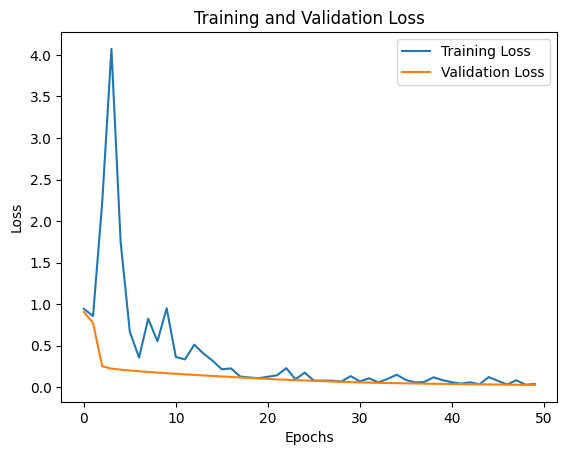

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2916

    accuracy                           1.00      2916
   macro avg       1.00      1.00      1.00      2916
weighted avg       1.00      1.00      1.00      2916



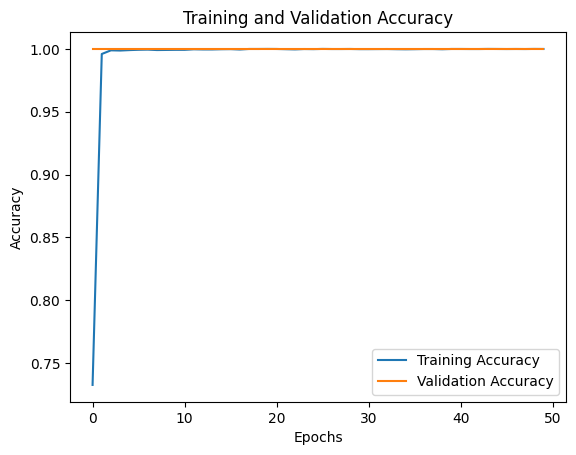

In [5]:
# Ensure data has no NaN values or extreme values
X_train_combined = np.nan_to_num(X_train_combined)
X_test_lstm = np.nan_to_num(X_test_lstm)
y_train_combined = np.nan_to_num(y_train_combined)
y_test_lstm = np.nan_to_num(y_test_lstm)

# Ensure labels are binary
print("Training labels distribution:", np.unique(y_train_combined, return_counts=True))
print("Testing labels distribution:", np.unique(y_test_lstm, return_counts=True))

# Normalize input data
scaler = MinMaxScaler()
X_train_combined = scaler.fit_transform(X_train_combined.reshape(-1, X_train_combined.shape[-1])).reshape(X_train_combined.shape)
X_test_lstm = scaler.transform(X_test_lstm.reshape(-1, X_test_lstm.shape[-1])).reshape(X_test_lstm.shape)

# Compute class weights correctly for binary classification
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_combined), y=y_train_combined)
class_weights_dict = dict(enumerate(class_weights))

# Print class weights to verify
print(f"Class Weights: {class_weights_dict}")

# Build LSTM model with Input layer
model = Sequential()

# Add Input layer and LSTM layers with regularization and dropout
model.add(Input(shape=(X_train_combined.shape[1], X_train_combined.shape[2])))
model.add(Bidirectional(LSTM(units=64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001))))
model.add(Dropout(0.4))  # Increase dropout for stronger regularization

model.add(Bidirectional(LSTM(units=32, activation='relu', return_sequences=False, kernel_regularizer=l2(0.001))))
model.add(Dropout(0.4))  # Add dropout to prevent overfitting

# Output layer for binary classification
model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=l2(0.001)))

optimizer = Adam(learning_rate=0.00001, clipnorm=1.0)  # Lower learning rate for more gradual learning
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)


# Train the model using class weights to handle class imbalance
history = model.fit(X_train_combined, y_train_combined, 
                    epochs=50, 
                    batch_size=64,  # Reduced batch size for better gradient updates
                    validation_data=(X_test_lstm, y_test_lstm),
                    class_weight=class_weights_dict, 
                    callbacks=[early_stopping, lr_scheduler])

# Visualize the training and validation loss to check for overfitting
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model using classification metrics
y_pred_lstm = (model.predict(X_test_lstm) > 0.5).astype("int32")
print(classification_report(y_test_lstm, y_pred_lstm))

# Optionally visualize accuracy if needed
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluate the Model
Now, we evaluate our model using various metrics like accuracy, precision, recall, and F1-score. Additionally, we will use the confusion matrix for a deeper understanding of the predictions

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


/opt/anaconda3/envs/CAM_Bootcamp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CAM_Bootcamp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CAM_Bootcamp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/ana

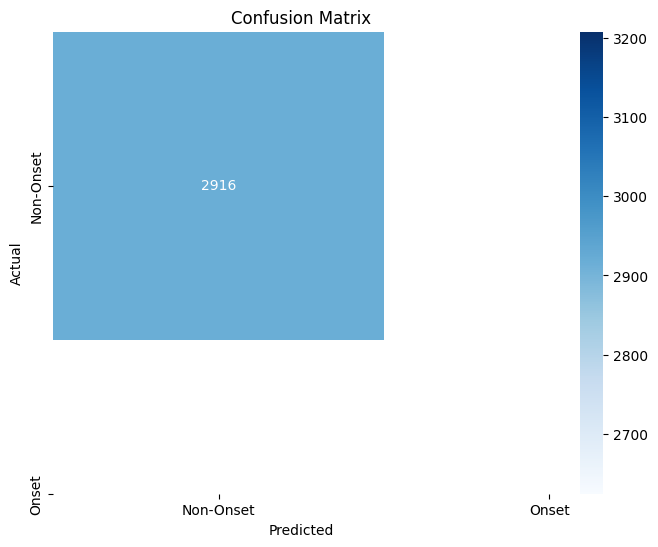

In [6]:
# Make predictions on the test set
y_pred_lstm = (model.predict(X_test_lstm) > 0.5).astype("int32")

# Evaluate the model
accuracy_lstm = accuracy_score(y_test_lstm, y_pred_lstm)
precision_lstm = precision_score(y_test_lstm, y_pred_lstm)
recall_lstm = recall_score(y_test_lstm, y_pred_lstm)
f1_lstm = f1_score(y_test_lstm, y_pred_lstm)

# Print the evaluation results
print(f"Accuracy: {accuracy_lstm}")
print(f"Precision: {precision_lstm}")
print(f"Recall: {recall_lstm}")
print(f"F1-Score: {f1_lstm}")

# Confusion matrix
cm = confusion_matrix(y_test_lstm, y_pred_lstm)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Onset', 'Onset'], yticklabels=['Non-Onset', 'Onset'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Visualize Training Performance

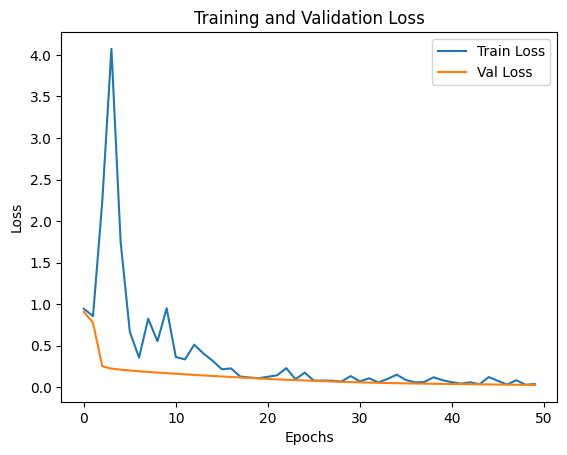

In [7]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
